### 0) Import packages for data extraction and exploratory analysis

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic


### 1.0) Data Extraction

In [45]:
#S&P 500 (stock prices)
sp500 = yf.download("^GSPC",start="1980-01-01")[["Close"]]
sp500 = sp500.rename(columns={"Close": "SP500"})

# 3-month T-Bill (^IRX on Yahoo gives yield in %)
t3m = yf.download("^IRX", start="1980-01-01")[["Close"]]
t3m = t3m.rename(columns={"Close": "TBILL_3M"})

# 10-year Treasury yield (^TNX also in %)
t10y = yf.download("^TNX", start="1980-01-01")[["Close"]]
t10y = t10y.rename(columns={"Close": "YIELD_10Y"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 1.1) Basic Data Inspection

In [46]:
print(sp500.head(), t3m.head(), t10y.head())
print(sp500.tail(), t3m.tail(), t10y.tail())
print(sp500.describe(), t3m.describe(), t10y.describe())

Price            SP500
Ticker           ^GSPC
Date                  
1980-01-02  105.760002
1980-01-03  105.220001
1980-01-04  106.519997
1980-01-07  106.809998
1980-01-08  108.949997 Price      TBILL_3M
Ticker         ^IRX
Date               
1980-01-02    12.17
1980-01-03    12.10
1980-01-04    12.10
1980-01-07    11.86
1980-01-08    11.78 Price      YIELD_10Y
Ticker          ^TNX
Date                
1980-01-02     10.50
1980-01-03     10.60
1980-01-04     10.66
1980-01-07     10.63
1980-01-08     10.57
Price             SP500
Ticker            ^GSPC
Date                   
2025-10-27  6875.160156
2025-10-28  6890.890137
2025-10-29  6890.589844
2025-10-30  6822.339844
2025-10-31  6840.200195 Price      TBILL_3M
Ticker         ^IRX
Date               
2025-10-27    3.718
2025-10-28    3.720
2025-10-29    3.730
2025-10-30    3.757
2025-10-31    3.718 Price      YIELD_10Y
Ticker          ^TNX
Date                
2025-10-27     3.997
2025-10-28     3.983
2025-10-29     4.058
2025-10-30

### 1.2) Resample to weekly frequence (last friday of each week), Merge DF, Drop NaNs and Describing

In [47]:
FREQ = "W-FRI"
sp500_w = sp500.resample(FREQ).last()
t3m_w   = t3m.resample(FREQ).last()
t10y_w  = t10y.resample(FREQ).last()

data = sp500_w.join([t3m_w, t10y_w], how="inner").dropna()
data.columns = ["S&P500", "YIELD_3M", "YIELD_10Y"]

print(data.describe())
print(data.corr())

#data.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/raw_dataset.csv")

            S&P500     YIELD_3M    YIELD_10Y
count  2392.000000  2392.000000  2392.000000
mean   1449.815469     4.024099     5.624991
std    1409.646085     3.454188     3.298025
min     100.550003    -0.058000     0.536000
25%     379.347496     0.921500     2.969250
50%    1123.309998     4.161500     4.775000
75%    1878.872498     5.650000     7.494250
max    6840.200195    16.680000    15.680000
             S&P500  YIELD_3M  YIELD_10Y
S&P500     1.000000 -0.413755  -0.609116
YIELD_3M  -0.413755  1.000000   0.926738
YIELD_10Y -0.609116  0.926738   1.000000


### 1.3) Data Visualization

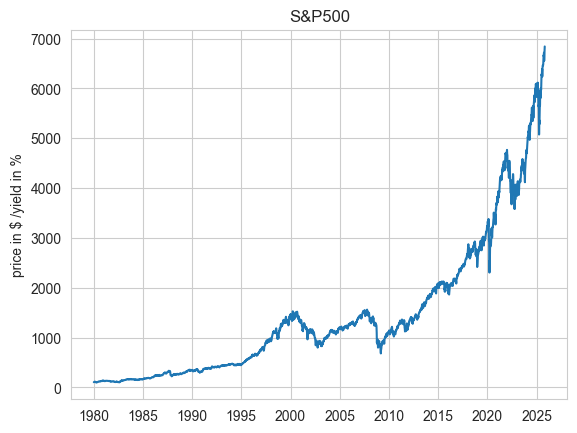

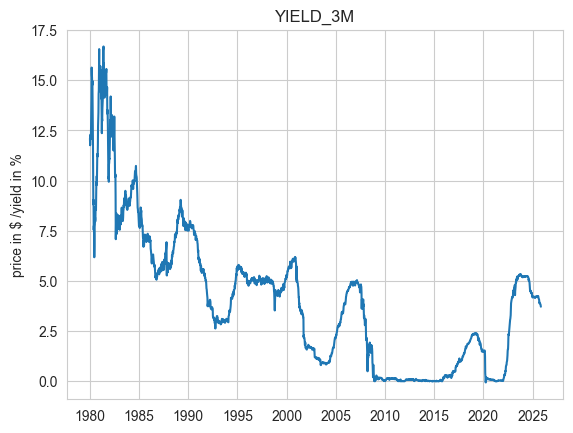

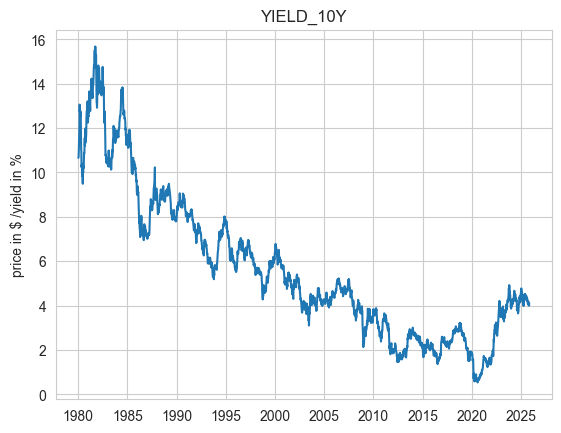

<Axes: >

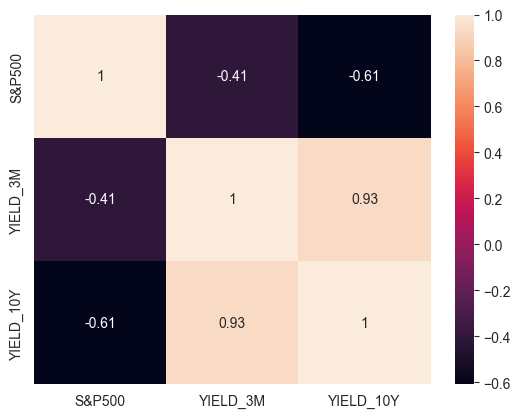

In [48]:
for column in data.columns:
    plt.plot(data[column], label=column)
    plt.title(column)
    plt.ylabel('price in $ /yield in %')
    plt.show()

sns.heatmap(data.corr(), annot=True)

### 1.4) Data transformation (ln differences for S&P 500 and simples differences for yields)

* S&P500: $r_t$ = $\log P_t$ - $\log P_{t-1}$
* Yields: $y_t$ = $y_t$ - $y_{t-1}$

In [49]:
data["spy_rt"] = np.log(data["S&P500"]).diff().dropna()
data["d_tbill"] = data["YIELD_3M"].diff().dropna()     # Δ i_t short-term
data["d_tbond"] = data["YIELD_10Y"].diff().dropna() # Δ i_t long-term

data_chg = data[["spy_rt", "d_tbill", "d_tbond"]]
#data_chg.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/data_chg.csv")

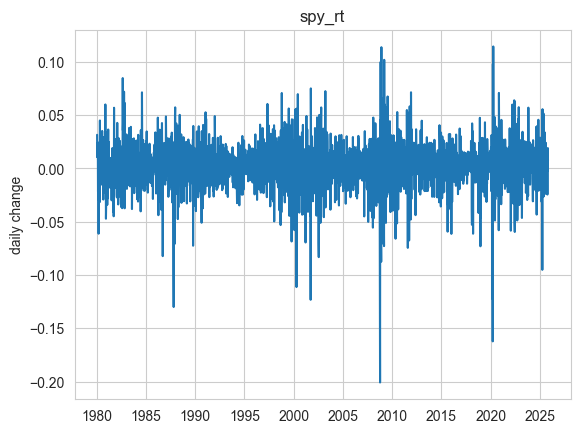

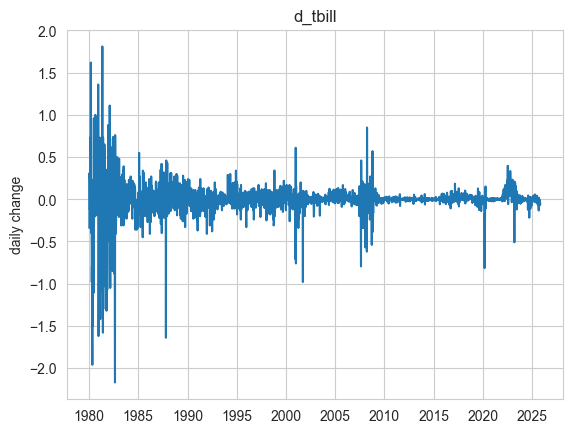

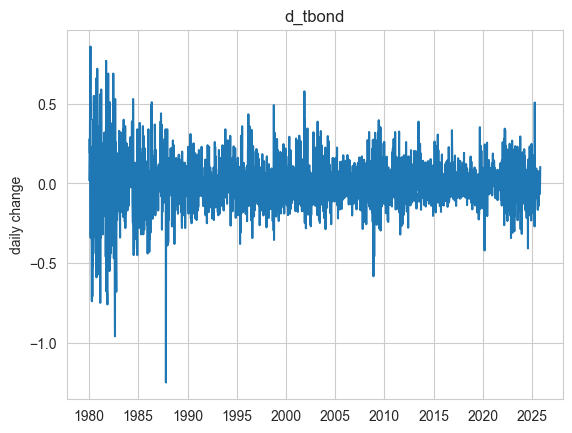

In [50]:
for column in data_chg.columns:
    plt.plot(data_chg[column], label=column, color=sns.color_palette()[0])
    plt.title(column)
    plt.ylabel('daily change')
    plt.show()

## Step 2: Testing for Stationarity (ADF)

In this step, we formally test whether our three transformed series are **stationary** — a key requirement before moving on to ARMA, GARCH, or VAR modeling.

The **Augmented Dickey–Fuller (ADF) test** is used to check for the presence of a **unit root** in each time series.


* $H_0$: Series has a unit root (non-stationary)

* $H_1$: Series is stationary $I(0)$


We apply the test to the following variables:

* ( $r_t$ = $\Delta$ $\log(P_t)$ ): S&P 500 log returns
* ( $\Delta$ $i_t^{(3M)}$ ): weekly change in the 3-month T-bill yield
* ( $\Delta$ $i_t^{(10Y)}$ ): weekly change in the 10-year bond yield

If the **p-value < 0.05**, we reject $H_0$ and conclude that the series is **stationary**.

This step ensures that our transformed variables are suitable for modeling with ARMA, GARCH, and VAR frameworks in the subsequent stages.



In [51]:
series_dict = {
    "r_t (Δ log P_t)": data_chg["spy_rt"].dropna(),
    "Δi_t (3M T-bill)": data_chg["d_tbill"].dropna(),
    "Δi_t (10Y bond)": data_chg["d_tbond"].dropna(),
}

def adf_summary(x):
    res = adfuller(x, autolag="AIC")
    stat, pval, lags, nobs, crit = res[0], res[1], res[2], res[3], res[4]
    return {
        "ADF_stat": stat,
        "p_value": pval,
        "lags_used": lags,
        "nobs": nobs,
        "cv_1%": crit.get("1%"),
        "cv_5%": crit.get("5%"),
        "cv_10%": crit.get("10%")
    }

results = pd.DataFrame({name: adf_summary(s) for name, s in series_dict.items()}).T
results = results[["ADF_stat","p_value","lags_used","nobs","cv_1%","cv_5%","cv_10%"]]


print("\nAugmented Dickey–Fuller (ADF) stationarity tests")
print("(H0: unit root; reject H0 ⇒ stationary / I(0))\n")
print(results.round(4))

#results.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/results.csv")



Augmented Dickey–Fuller (ADF) stationarity tests
(H0: unit root; reject H0 ⇒ stationary / I(0))

                  ADF_stat  p_value  lags_used    nobs   cv_1%   cv_5%  cv_10%
r_t (Δ log P_t)   -25.6261      0.0        3.0  2387.0 -3.4331 -2.8628 -2.5674
Δi_t (3M T-bill)  -11.3787      0.0       27.0  2363.0 -3.4331 -2.8628 -2.5674
Δi_t (10Y bond)   -21.9002      0.0        3.0  2387.0 -3.4331 -2.8628 -2.5674


## Step 2.2: Ploting ACF and PACF for Log returns of S&P 500

- as we can see there is no significant autocorrelation in any lags

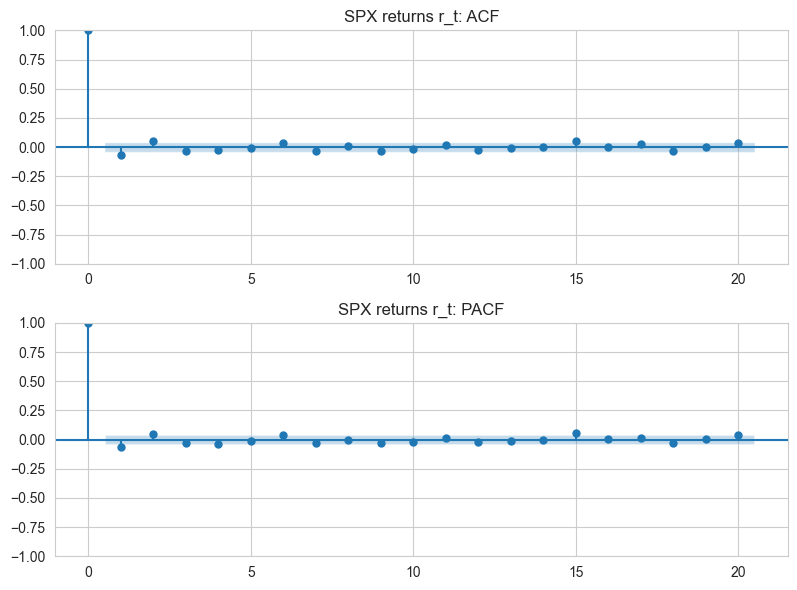

In [52]:
r_spx = data["spy_rt"]
r_spx = pd.to_numeric(r_spx, errors="coerce").dropna()

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(r_spx.values, lags=20, ax=ax[0])                    # pass a plain 1-D array
ax[0].set_title("SPX returns r_t: ACF")
plot_pacf(r_spx.values, lags=20, method="ywm", ax=ax[1])
ax[1].set_title("SPX returns r_t: PACF")
plt.tight_layout(); plt.show()

## Step 3: Modeling Short-Run Dynamics with ARMA

We now model the short-term behavior of the **S&P 500 log returns** ( $r_t$ = $\Delta$ $\log P_t$ ) using an **Autoregressive Moving Average (ARMA)** model.

Formally:

$$
r_t = \mu + \sum_{i=1}^{p} \phi_i r_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t
$$

where:

* $\phi_i$ are the **autoregressive coefficients** capturing momentum or mean reversion,
* $\theta_j$ are the **moving average coefficients** capturing shock persistence, and
* $\varepsilon_t$ is a white-noise innovation with  $E$($\varepsilon_t$)=0  and $Var$($\varepsilon_t$)=$\sigma^2$.

The orders (p,q) are identified by minimizing the **Akaike Information Criterion (AIC)**, following the same procedure used in the course notes.

Once the best ARMA specification is selected, we will later analyze its residuals to model conditional volatility using **GARCH**.


In [53]:
y = data_chg["spy_rt"].dropna()

# Define search grid for p and q
pq_grid = [(p, q) for p in range(0, 4) for q in range(0, 4) if not (p == 0 and q == 0)]

best_ic = np.inf
best_order = None
best_res = None

for p, q in pq_grid:
    try:
        model = ARIMA(y, order=(p, 0, q))
        res = model.fit(method_kwargs={"warn_convergence": False})
        ic = res.aic
        print(f"(p={p}, q={q})  AIC={ic:.2f}")
        if ic < best_ic:
            best_ic = ic
            best_order = (p, q)
            best_res = res
    except Exception:
        continue

print(f"\nBest ARMA order by AIC: p={best_order[0]}, q={best_order[1]} (AIC={best_ic:.2f})")
print(best_res.summary())

#best_res.summary().to_csv("/Users/eduardo/Desktop/FinancialEconometrics/best_model_summary.csv")


(p=0, q=1)  AIC=-11235.95
(p=0, q=2)  AIC=-11239.82
(p=0, q=3)  AIC=-11241.26
(p=1, q=0)  AIC=-11236.81
(p=1, q=1)  AIC=-11240.08
(p=1, q=2)  AIC=-11238.65
(p=1, q=3)  AIC=-11238.60
(p=2, q=0)  AIC=-11240.41
(p=2, q=1)  AIC=-11238.60
(p=2, q=2)  AIC=-11238.86
(p=2, q=3)  AIC=-11239.13
(p=3, q=0)  AIC=-11240.46


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(p=3, q=1)  AIC=-11238.61
(p=3, q=2)  AIC=-11240.59
(p=3, q=3)  AIC=-11237.82

Best ARMA order by AIC: p=0, q=3 (AIC=-11241.26)
                               SARIMAX Results                                
Dep. Variable:                 spy_rt   No. Observations:                 2391
Model:                 ARIMA(0, 0, 3)   Log Likelihood                5625.628
Date:                Sun, 02 Nov 2025   AIC                         -11241.255
Time:                        19:49:09   BIC                         -11212.358
Sample:                    01-11-1980   HQIC                        -11230.740
                         - 10-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      3.453      0.001       0.001       0.003
ma.

## Step 4: Modeling Conditional Volatility with GARCH(1,1)

We now model the **time-varying volatility** of the S&P 500 returns using a **GARCH(1,1)** specification, as the residuals from the ARMA(0,3) model exhibit non-constant variance.

Formally:

$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

where:

* $\alpha$: measures the short-run impact of shocks on volatility, and
* $\beta$:  captures volatility persistence.

This step captures **volatility clustering**, a key feature of financial time series, where large movements in returns tend to be followed by periods of high volatility.


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5108.88
Distribution:                  Normal   AIC:                           10223.8
Method:            Maximum Likelihood   BIC:                           10241.1
                                        No. Observations:                 2391
Date:                Sun, Nov 02 2025   Df Residuals:                     2391
Time:                        19:49:09   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.2982  8.183e-02      3.644  2.683e-04 [  0.138,  0.45

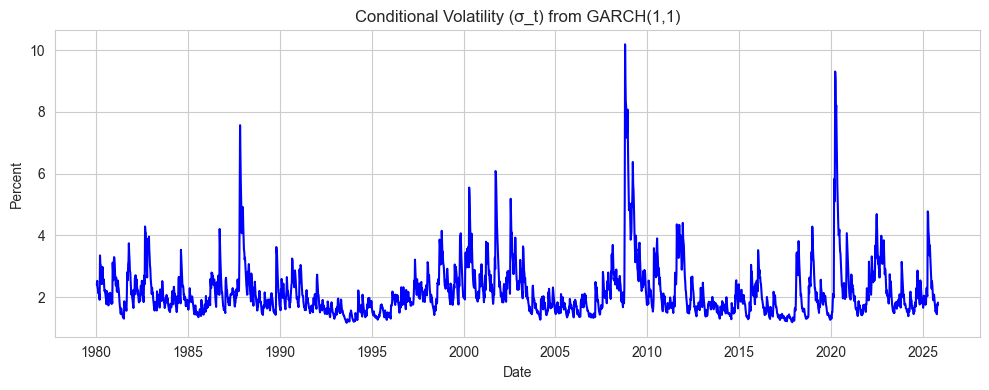

In [54]:
# Residuals from best ARMA(0,3)
residuals = best_res.resid.dropna()

# Fit GARCH(1,1) on returns (mean zero specification)
am = arch_model(residuals * 100, vol='GARCH', p=1, q=1, mean='Zero')
garch_res = am.fit(disp='off')

print(garch_res.summary())

# Plot conditional volatility
plt.figure(figsize=(10, 4))
plt.plot(garch_res.conditional_volatility, color='blue')
plt.title('Conditional Volatility (σ_t) from GARCH(1,1)')
plt.ylabel('Percent')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

#garch_res.summary().to_csv("/Users/eduardo/Desktop/FinancialEconometrics/garchsummary.csv")


### Step 5 — VAR between $r_t$ and $\Delta$ $i_t^{(10Y)}$

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.19     -11.19*   1.376e-05      -11.19
1      -11.20      -11.18   1.372e-05      -11.19
2      -11.20      -11.18   1.364e-05     -11.19*
3      -11.20      -11.17   1.363e-05      -11.19
4      -11.20      -11.16   1.362e-05      -11.19
5      -11.20      -11.15   1.366e-05      -11.18
6      -11.20      -11.14   1.363e-05      -11.18
7      -11.20      -11.13   1.362e-05      -11.18
8     -11.20*      -11.12  1.361e-05*      -11.17
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Nov, 2025
Time:                     19:49:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.1223
Nobs:                     2383.00    

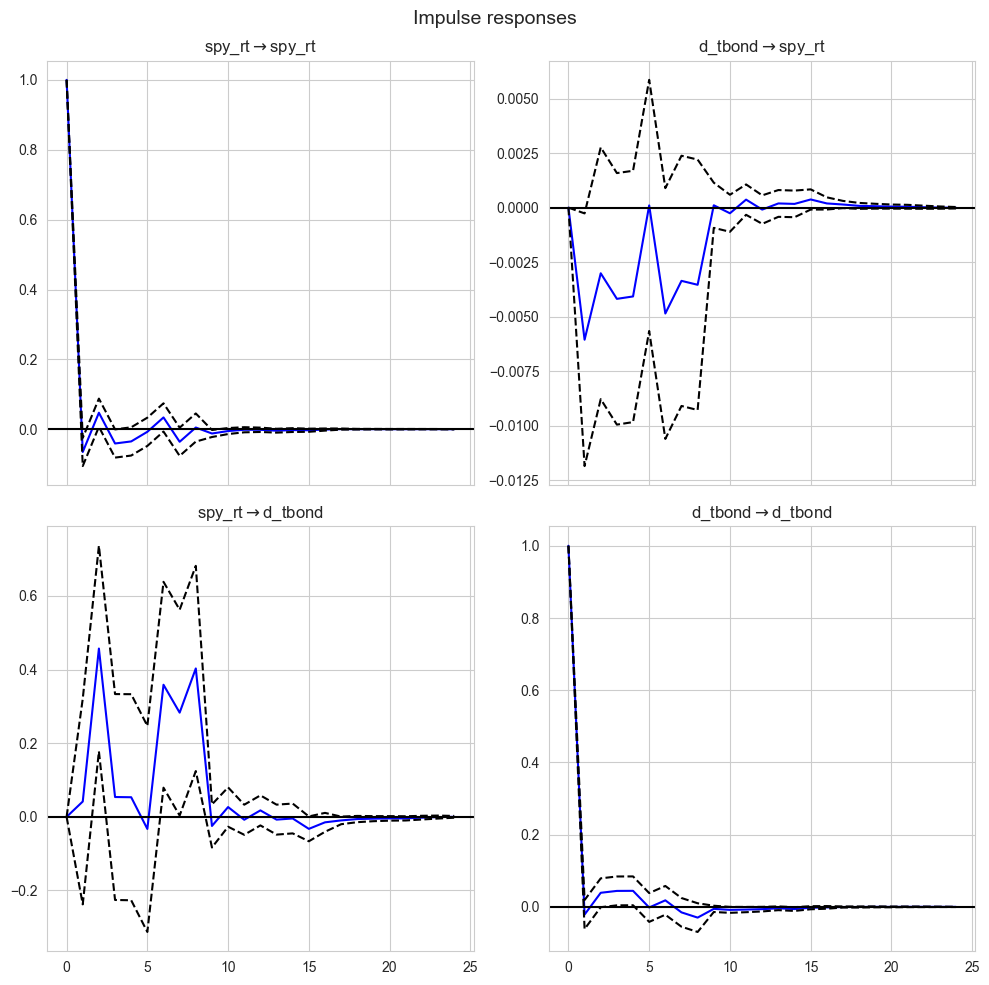


H0: Δi_t (10Y) does NOT Granger-cause r_t
Granger causality F-test. H_0: d_tbond does not Granger-cause spy_rt. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.050          1.940   0.037 (8, 4732)
-----------------------------------------------

H0: r_t does NOT Granger-cause Δi_t (10Y)
Granger causality F-test. H_0: spy_rt does not Granger-cause d_tbond. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         3.513          1.940   0.000 (8, 4732)
-----------------------------------------------


In [55]:
# Prepare data for VAR
Z = data_chg[["spy_rt", "d_tbond"]].dropna()

# Select optimal lag order
var_model = VAR(Z)
lag_selection = var_model.select_order(maxlags=8)
print(lag_selection.summary())

# Fit VAR(p) using AIC-selected lag
p_opt = lag_selection.aic
var_res = var_model.fit(p_opt)
print(var_res.summary())

# Plot Impulse Response Functions (24 weeks or 0.5 year ahead)
irf = var_res.irf(24)
irf.plot(orth=False)
plt.tight_layout()
plt.show()

# Granger causality tests
print("\nH0: Δi_t (10Y) does NOT Granger-cause r_t")
print(var_res.test_causality(caused="spy_rt", causing=["d_tbond"], kind="f").summary())

print("\nH0: r_t does NOT Granger-cause Δi_t (10Y)")
print(var_res.test_causality(caused="d_tbond", causing=["spy_rt"], kind="f").summary())

#var_res.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_summary.csv")


### Step 6 — Save VAR(7) output and key statistics

In [56]:
stats = {
    "aic": [var_res.aic],
    "bic": [var_res.bic],
    "hqic": [getattr(var_res, "hqic", None)],
    "nobs": [var_res.nobs],
    "selected_lags": [var_res.k_ar]
}

stats_df = pd.DataFrame(stats)
#stats_df.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_model_stats.csv", index=False)
params_df = pd.DataFrame(var_res.params)
#params_df.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_model_params.csv", index=False)


### Step 8 — Orthogonalized IRFs with COVID & Rate Hike Dummies


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.19     -11.18*   1.380e-05      -11.19
1      -11.19      -11.17   1.375e-05      -11.19
2      -11.20      -11.17   1.367e-05     -11.19*
3      -11.20      -11.16   1.367e-05      -11.18
4      -11.20      -11.15   1.365e-05      -11.18
5      -11.20      -11.14   1.370e-05      -11.18
6      -11.20      -11.13   1.366e-05      -11.17
7      -11.20      -11.12   1.366e-05      -11.17
8     -11.20*      -11.11  1.364e-05*      -11.17
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Nov, 2025
Time:                     19:49:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.1102
Nobs:                     2383.00    

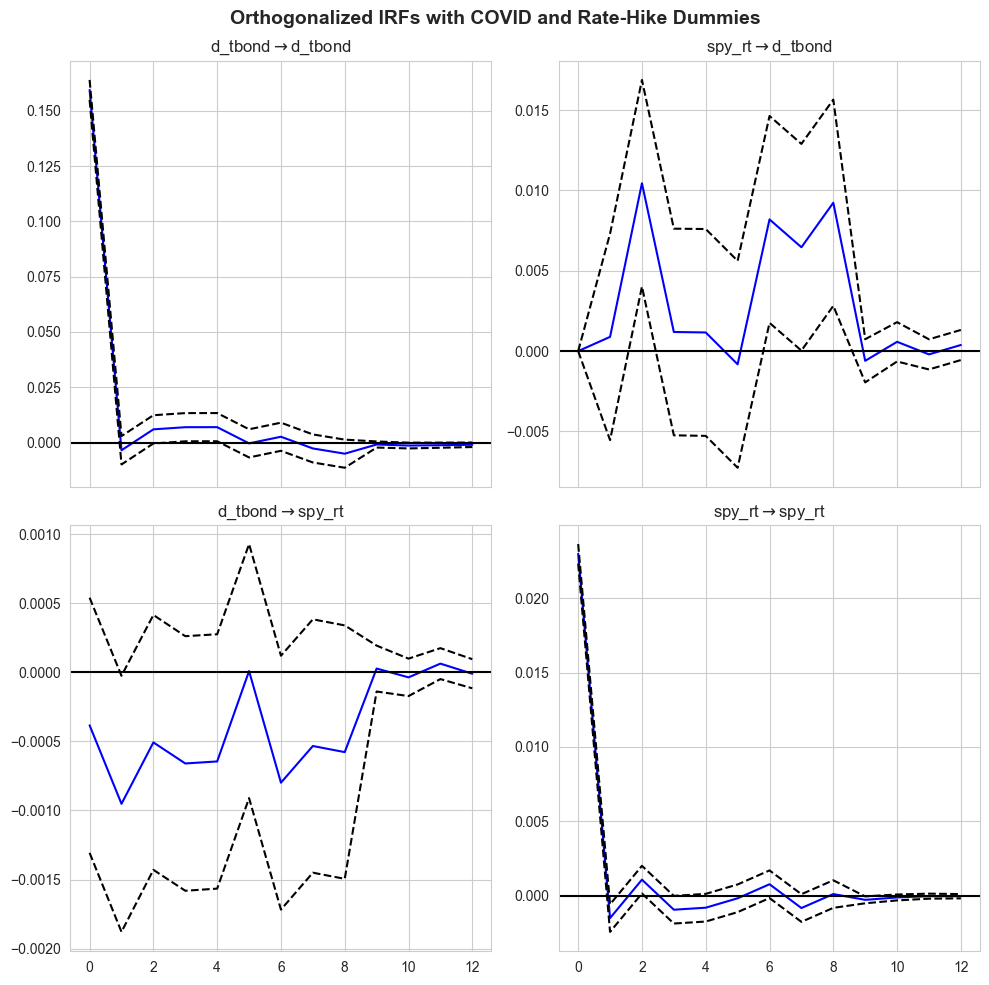

Saved orthogonalized IRFs and model parameters with exogenous dummies.


In [57]:
# Prepare data
Z = data_chg[["d_tbond", "spy_rt"]].dropna()  # order: rates first, returns second

# Create exogenous dummies
exog = pd.DataFrame(index=Z.index)
exog["covid"] = ((exog.index >= "2020-03-01") & (exog.index <= "2020-06-30")).astype(int)
exog["rate_hike"] = (exog.index >= "2022-03-01").astype(int)

# Fit VAR with exogenous dummies
var_ex = VAR(endog=Z, exog=exog)
lag_selection = var_ex.select_order(maxlags=8)
print(lag_selection.summary())

p_opt = lag_selection.aic
var_ex_res = var_ex.fit(p_opt)
print(var_ex_res.summary())

# Orthogonalized IRFs (Cholesky, order: rates → returns)
irf_ex = var_ex_res.irf(12)
fig = irf_ex.plot(orth=True)
plt.suptitle("Orthogonalized IRFs with COVID and Rate-Hike Dummies", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# Save IRF results and parameters
os.makedirs("/Users/eduardo/Desktop/FinancialEconometrics", exist_ok=True)
irf_ex_df = irf_ex.irfs.reshape(irf_ex.irfs.shape[0], -1)
cols = [f"response_{i}_{j}" for i in Z.columns for j in Z.columns]
pd.DataFrame(irf_ex_df, columns=cols).to_csv(
    "/Users/eduardo/Desktop/FinancialEconometrics/irf_exog_results.csv", index=False
)
var_ex_res.params.to_csv(
    "/Users/eduardo/Desktop/FinancialEconometrics/var_exog_params.csv"
)
print("Saved orthogonalized IRFs and model parameters with exogenous dummies.")
